In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data Reading and Preprocessing

In [33]:
dataset = pd.read_csv('../HW1_data/traffic/Casualties0514.csv')

## Deal with skewed data: resample

In [34]:
# dataset.groupby("Casualty_Severity").count()
fatal_dataset = dataset[dataset["Casualty_Severity"]==1]
num_fatal = fatal_dataset.shape[0]
serious_dataset = dataset[dataset["Casualty_Severity"]==2].sample(n=num_fatal, random_state=35674, axis=0)
slight_dataset = dataset[dataset["Casualty_Severity"]==3].sample(n=num_fatal, random_state=25442, axis=0)
dataset = pd.concat([fatal_dataset, serious_dataset, slight_dataset],axis=0)
del fatal_dataset, serious_dataset, slight_dataset

In [35]:
dataset = dataset.drop(["Accident_Index", "Vehicle_Reference", "Casualty_Reference"], axis=1)
dataset = dataset.sample(frac=1, axis=0)
dataset.head()

,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type
1884347,3,1,59,9,1,5,3,0,0,0,0,3
1527962,1,1,30,6,1,0,0,0,0,0,9,1
1899098,3,2,45,7,1,6,9,0,0,0,0,1
1262549,1,1,20,4,2,0,0,0,0,-1,9,1
1485824,3,2,82,11,2,1,1,0,0,0,0,-1


## Splitting Data

In [36]:
# Prepare data for Decision Tree
from sklearn.model_selection import train_test_split
X = dataset.drop(["Casualty_Severity"], axis=1)
y = dataset["Casualty_Severity"]
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6357)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size=0.2, random_state=6357)
del X, y
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(44297, 11)
(11075, 11)
(13844, 11)


# Decision Tree

## Try it

In [37]:
from sklearn.tree import DecisionTreeClassifier
import pydotplus as pydot
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn import tree

# Vanilla Decision Tree
dt = DecisionTreeClassifier(criterion="entropy", random_state=4321)
dt.fit(X_train, y_train)
print("Fit end! ")
dt_val_score = dt.score(X_val, y_val)
print("Validation score: ", dt_val_score)

Fit end! 
Validation score:  0.43909706546275395


## Implement post-prune

In [38]:
# Post-prune Decision Tree 
# My own implementation based on https://stackoverflow.com/questions/49428469/pruning-decision-trees/49496027#49496027
# Pruning based on validation score (if pruning a subtree gains better performance on validate set, then prune it)
from sklearn.tree._tree import TREE_LEAF

def prune_from_root(inner_tree, index):
    global dt_val_score
    memo = (inner_tree.children_left[index], inner_tree.children_right[index])
    inner_tree.children_left[index] = TREE_LEAF
    inner_tree.children_right[index] = TREE_LEAF
    new_score = dt.score(X_val, y_val)
    if new_score <= dt_val_score:
        inner_tree.children_left[index] = memo[0]
        inner_tree.children_right[index] = memo[1]
    else:
        dt_val_score = new_score

    # if there are children, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_from_root(inner_tree, inner_tree.children_left[index])
        prune_from_root(inner_tree, inner_tree.children_right[index])

def prune_from_leaf(inner_tree, index):
    global dt_val_score
    # if there are children, firstly visit them
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_from_leaf(inner_tree, inner_tree.children_left[index])
        prune_from_leaf(inner_tree, inner_tree.children_right[index])
        memo = (inner_tree.children_left[index], inner_tree.children_right[index])
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        new_score = dt.score(X_val, y_val)
        if new_score <= dt_val_score:
            inner_tree.children_left[index] = memo[0]
            inner_tree.children_right[index] = memo[1]
        else:
            dt_val_score = new_score

## Prune from root experiment

In [102]:
# prune from root
dt = DecisionTreeClassifier(criterion="entropy", random_state=4321)
dt.fit(X_train, y_train)
dt_val_score = dt.score(X_val, y_val)
print("no-prune validation score: ", dt_val_score)
print("no-prune test score: ", dt.score(X_test, y_test))
prune_from_root(dt.tree_, 0)
print("post-prune from root validation score: ", dt.score(X_val, y_val))
print("post-prune from root test score: ", dt.score(X_test, y_test))

no-prune validation score:  0.43873589164785554
no-prune test score:  0.4460416064721179
post-prune from root validation score:  0.4588713318284424
post-prune from root test score:  0.46865067899451024


## Prune from leaf experiment

In [103]:
# prune from leaf
# create an identical decision tree to the previous one using the same random_state
dt = DecisionTreeClassifier(criterion="entropy", random_state=4321)
dt.fit(X_train, y_train)
dt_val_score = dt.score(X_val, y_val)
print("no-prune validation score: ", dt_val_score)
print("no-prune test score: ", dt.score(X_test, y_test))
prune_from_leaf(dt.tree_, 0)
print("post-prune from leaf validation score: ", dt.score(X_val, y_val))
print("post-prune from leaf test score: ", dt.score(X_test, y_test))

no-prune validation score:  0.43873589164785554
no-prune test score:  0.4460416064721179
post-prune from leaf validation score:  0.5398645598194131
post-prune from leaf test score:  0.46850621207743426


## Hyperparameter Tuning using CV

In [106]:
# pre prune + post prune
best_val = 0
best_val_depth = 0
best_post_prune = ""
for depth in range(1, 30):
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=4321)
    dt.fit(X_train, y_train)
    dt_val_score = dt.score(X_val, y_val)
    print("===================", "depth=%d, post-prune=from root" % depth, sep='\n')
    print("no-prune validation score: ", dt_val_score)
    print("no-prune test score: ", dt.score(X_test, y_test))
    prune_from_root(dt.tree_, 0)
    val_score = dt.score(X_val, y_val)
    print("post-prune from root validation score: ", val_score)
    if val_score > best_val:
        best_val = val_score
        best_val_depth = depth
        best_post_prune = "from root"
    print("post-prune from root test score: ", dt.score(X_test, y_test))
    
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=depth, random_state=4321)
    dt.fit(X_train, y_train)
    dt_val_score = dt.score(X_val, y_val)
    print("===================", "depth=%d, post-prune=from leaf" % depth, sep='\n')
    print("no-prune validation score: ", dt_val_score)
    print("no-prune test score: ", dt.score(X_test, y_test))
    prune_from_leaf(dt.tree_, 0)
    val_score = dt.score(X_val, y_val)
    print("post-prune from leaf validation score: ", val_score)
    if val_score >= best_val:
        best_val = val_score
        best_val_depth = depth
        best_post_prune = "from leaf"
    print("post-prune from leaf test score: ", dt.score(X_test, y_test))
print("*********************")
print("best_val=%f, best_val_depth=%d, best_post_prune=%s" % (best_val, best_val_depth, best_post_prune))

depth=1, post-prune=from root
no-prune validation score:  0.4302483069977427
no-prune test score:  0.43433978618896274
post-prune from root validation score:  0.4302483069977427
post-prune from root test score:  0.43433978618896274
depth=1, post-prune=from leaf
no-prune validation score:  0.4302483069977427
no-prune test score:  0.43433978618896274
post-prune from leaf validation score:  0.4302483069977427
post-prune from leaf test score:  0.43433978618896274
depth=2, post-prune=from root
no-prune validation score:  0.43548532731376977
no-prune test score:  0.4328951170182028
post-prune from root validation score:  0.43548532731376977
post-prune from root test score:  0.4328951170182028
depth=2, post-prune=from leaf
no-prune validation score:  0.43548532731376977
no-prune test score:  0.4328951170182028
post-prune from leaf validation score:  0.43548532731376977
post-prune from leaf test score:  0.4328951170182028
depth=3, post-prune=from root
no-prune validation score:  0.464288939051

post-prune from leaf validation score:  0.5272234762979684
post-prune from leaf test score:  0.48129153423865934
depth=18, post-prune=from root
no-prune validation score:  0.45580135440180586
no-prune test score:  0.46056053163825483
post-prune from root validation score:  0.4817155756207675
post-prune from root test score:  0.485842242126553
depth=18, post-prune=from leaf
no-prune validation score:  0.45580135440180586
no-prune test score:  0.46056053163825483
post-prune from leaf validation score:  0.531647855530474
post-prune from leaf test score:  0.4775353943946836
depth=19, post-prune=from root
no-prune validation score:  0.4524604966139955
no-prune test score:  0.458176827506501
post-prune from root validation score:  0.4817155756207675
post-prune from root test score:  0.485842242126553
depth=19, post-prune=from leaf
no-prune validation score:  0.4524604966139955
no-prune test score:  0.458176827506501
post-prune from leaf validation score:  0.5337246049661399
post-prune from l

## Run Result

In [40]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=27, random_state=4321)
dt.fit(X_train, y_train)
dt_val_score = dt.score(X_val, y_val)
print("no-prune training score: ", dt.score(X_train, y_train))
print("no-prune validation score: ", dt_val_score)
print("no-prune test score: ", dt.score(X_test, y_test))
prune_from_leaf(dt.tree_, 0)
val_score = dt.score(X_val, y_val)
print("post-prune from leaf training score: ", dt.score(X_train, y_train))
print("post-prune from leaf validation score: ", val_score)
print("post-prune from leaf test score: ", dt.score(X_test, y_test))

no-prune training score:  0.648102580310179
no-prune validation score:  0.4396388261851016
no-prune test score:  0.43932389482808437
post-prune from leaf training score:  0.5920942727498476
post-prune from leaf validation score:  0.5441083521444695
post-prune from leaf test score:  0.46749494365790234


# Boosting

## Hyperparameter Tuning using CV

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

best_val = 0
best_depth = 0
best_n_estimators = 0
for depth in range(1, 10):
    for n_estimators in [100, 200, 400, 1000]:
        ada_dt = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
        adaboost = AdaBoostClassifier(base_estimator=ada_dt, n_estimators=n_estimators)
        adaboost.fit(X_train,y_train)
        val_score = adaboost.score(X_val,y_val)
        print("max_depth=%d, n_estimator=%d, val_score=%f" % (depth, n_estimators, val_score))
        if val_score > best_val:
            best_val = val_score
            best_depth = depth
            best_n_estimators = n_estimators
            
print("Best validation score: ", best_val)
print("Best depth: ", best_depth)
print("Best estimators: ", best_n_estimators)
ada_dt = DecisionTreeClassifier(criterion="entropy", max_depth=best_depth)
adaboost = AdaBoostClassifier(base_estimator=ada_dt, n_estimators=best_n_estimators)
adaboost.fit(X_train,y_train)
test_score = adaboost.score(X_test, y_test)
print("Test score: ", test_score)

//anaconda/envs/7641ML/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


NameError: name 'DecisionTreeClassifier' is not defined

## Draw Iterative Training Curve

Val score:  0.5034762979683973
Test score:  0.50072233458538


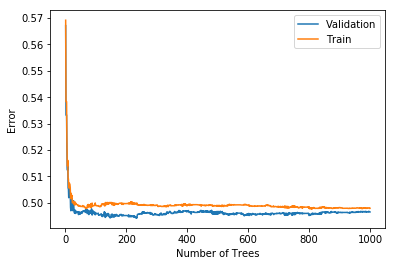

In [44]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

ada_dt = DecisionTreeClassifier(criterion="entropy", max_depth=1)
adaboost = AdaBoostClassifier(base_estimator=ada_dt, n_estimators=1000)
adaboost.fit(X_train,y_train)
val_score = adaboost.score(X_val, y_val)
print("Val score: ", val_score)
test_score = adaboost.score(X_test, y_test)
print("Test score: ", test_score)

train_mid_error = []
for mid_predict in adaboost.staged_predict(X_train):
    train_mid_error.append(1 - accuracy_score(mid_predict, y_train))
val_mid_error = []
for mid_predict in adaboost.staged_predict(X_val):
    val_mid_error.append(1 - accuracy_score(mid_predict, y_val))

number_of_predict = len(val_mid_error)
train_mid_error = train_mid_error[:number_of_predict]

plt.plot(range(1, number_of_predict + 1),
         val_mid_error, label='Validation')
plt.plot(range(1, number_of_predict + 1),
         train_mid_error, label='Train')
plt.legend()
plt.ylabel('Error')
plt.xlabel('Number of Trees')
plt.show()

## Run Result

In [45]:
ada_dt = DecisionTreeClassifier(criterion="entropy", max_depth=1)
adaboost = AdaBoostClassifier(base_estimator=ada_dt, n_estimators=1000)
adaboost.fit(X_all_train,y_all_train)
print("Training score: ", adaboost.score(X_train, y_train))
test_score = adaboost.score(X_test, y_test)
print("Test score: ", test_score)

Training score:  0.5011400320563469
Test score:  0.5010835018780699


# Preprocess data to onehot

In [46]:
dataset = pd.read_csv('../HW1_data/traffic/Casualties0514.csv')
dataset.head()
# dataset.groupby("Casualty_Severity").count()
fatal_dataset = dataset[dataset["Casualty_Severity"]==1]
num_fatal = fatal_dataset.shape[0]
serious_dataset = dataset[dataset["Casualty_Severity"]==2].sample(n=num_fatal, random_state=35674, axis=0)
slight_dataset = dataset[dataset["Casualty_Severity"]==3].sample(n=num_fatal, random_state=25442, axis=0)
dataset = pd.concat([fatal_dataset, serious_dataset, slight_dataset],axis=0)
del fatal_dataset, serious_dataset, slight_dataset
dataset = dataset.drop(["Accident_Index", "Vehicle_Reference", "Casualty_Reference"], axis=1)
dataset = dataset.sample(frac=1, axis=0)
dataset.head()

,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type
436699,1,1,22,5,2,0,0,0,0,-1,5,1
2007290,1,1,17,4,1,0,0,0,0,0,1,1
2064356,1,1,29,6,3,0,0,0,0,0,1,1
2115758,2,2,25,5,3,0,0,2,0,0,9,1
1543466,3,2,13,3,2,1,1,0,0,0,0,1


In [47]:
for col in ["Casualty_Class", "Sex_of_Casualty", "Age_Band_of_Casualty", "Pedestrian_Location", "Pedestrian_Movement", "Car_Passenger", "Bus_or_Coach_Passenger", "Pedestrian_Road_Maintenance_Worker", "Casualty_Type", "Casualty_Home_Area_Type"]: 
    need_remove_non = False
    if dataset[col].min() < 0:
        need_remove_non = True
    dataset = pd.concat([dataset,pd.get_dummies(dataset[col], prefix=col)],axis=1).drop([col],axis=1)
    if need_remove_non:
        dataset = dataset.drop([col+"_-1"], axis=1)
dataset.head()

,Age_of_Casualty,Casualty_Severity,Casualty_Class_1,Casualty_Class_2,Casualty_Class_3,Sex_of_Casualty_1,Sex_of_Casualty_2,Age_Band_of_Casualty_1,Age_Band_of_Casualty_2,Age_Band_of_Casualty_3,...,Casualty_Type_18,Casualty_Type_19,Casualty_Type_20,Casualty_Type_21,Casualty_Type_22,Casualty_Type_90,Casualty_Type_97,Casualty_Home_Area_Type_1,Casualty_Home_Area_Type_2,Casualty_Home_Area_Type_3
436699,22,2,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2007290,17,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2064356,29,3,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2115758,25,3,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1543466,13,2,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [48]:
dataset.columns

Index(['Age_of_Casualty', 'Casualty_Severity', 'Casualty_Class_1',
       'Casualty_Class_2', 'Casualty_Class_3', 'Sex_of_Casualty_1',
       'Sex_of_Casualty_2', 'Age_Band_of_Casualty_1', 'Age_Band_of_Casualty_2',
       'Age_Band_of_Casualty_3', 'Age_Band_of_Casualty_4',
       'Age_Band_of_Casualty_5', 'Age_Band_of_Casualty_6',
       'Age_Band_of_Casualty_7', 'Age_Band_of_Casualty_8',
       'Age_Band_of_Casualty_9', 'Age_Band_of_Casualty_10',
       'Age_Band_of_Casualty_11', 'Pedestrian_Location_0',
       'Pedestrian_Location_1', 'Pedestrian_Location_2',
       'Pedestrian_Location_3', 'Pedestrian_Location_4',
       'Pedestrian_Location_5', 'Pedestrian_Location_6',
       'Pedestrian_Location_7', 'Pedestrian_Location_8',
       'Pedestrian_Location_9', 'Pedestrian_Location_10',
       'Pedestrian_Movement_0', 'Pedestrian_Movement_1',
       'Pedestrian_Movement_2', 'Pedestrian_Movement_3',
       'Pedestrian_Movement_4', 'Pedestrian_Movement_5',
       'Pedestrian_Movement_6', 

In [49]:
X = dataset.drop(["Casualty_Severity"], axis=1)
y = dataset["Casualty_Severity"]

In [50]:
print(X.shape)
print(y.shape)

(69216, 71)
(69216,)


In [51]:
from sklearn.model_selection import train_test_split
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6357)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size=0.2, random_state=6357)
del X, y
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(44297, 71)
(11075, 71)
(13844, 71)


In [52]:
X_train.describe()

,Age_of_Casualty,Casualty_Class_1,Casualty_Class_2,Casualty_Class_3,Sex_of_Casualty_1,Sex_of_Casualty_2,Age_Band_of_Casualty_1,Age_Band_of_Casualty_2,Age_Band_of_Casualty_3,Age_Band_of_Casualty_4,...,Casualty_Type_18,Casualty_Type_19,Casualty_Type_20,Casualty_Type_21,Casualty_Type_22,Casualty_Type_90,Casualty_Type_97,Casualty_Home_Area_Type_1,Casualty_Home_Area_Type_2,Casualty_Home_Area_Type_3
count,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,...,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000,44297.000000
mean,37.568549,0.614624,0.197327,0.188049,0.667901,0.331873,0.014719,0.022507,0.044021,0.146308,...,0.000045,0.019302,0.002890,0.007201,0.000406,0.006321,0.000090,0.621464,0.090909,0.124297
std,20.894259,0.486690,0.397986,0.390756,0.470972,0.470891,0.120426,0.148328,0.205144,0.353419,...,0.006719,0.137584,0.053678,0.084556,0.020154,0.079254,0.009502,0.485028,0.287483,0.329924
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,51.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Neural Network

## Hyperparameter Tuning using CV

In [128]:
from sklearn.neural_network import MLPClassifier

best_val = 0
best_layer = (0)
best_activation = ""
for first_layer in range(100, 301, 100):
    for activation in ['identity', 'logistic', 'tanh', 'relu']:
        mlp = MLPClassifier(hidden_layer_sizes=(first_layer), activation=activation, max_iter=1000)
        mlp.fit(X_train, y_train)
        val_score = mlp.score(X_val, y_val)
        print("first_layer=%d, activation=%s, val_score=%f" % (first_layer, activation, val_score))
        if val_score > best_val:
            best_val = val_score
            best_layer = (first_layer)
            best_activation = activation
    for second_layer in range(100, 301, 100):
        for activation in ['identity', 'logistic', 'tanh', 'relu']:
            mlp = MLPClassifier(hidden_layer_sizes=(first_layer, second_layer), activation=activation, max_iter=1000)
            mlp.fit(X_train, y_train)
            val_score = mlp.score(X_val, y_val)
            print("first_layer=%d, second_layer=%d, activation=%s, val_score=%f" % (first_layer, second_layer, activation, val_score))
            if val_score > best_val:
                best_val = val_score
                best_layer = (first_layer, second_layer)
                best_activation = activation

print(best_val)
print(best_layer)
print(best_activation)

first_layer=100, activation=identity, val_score=0.479910
first_layer=100, activation=logistic, val_score=0.499594
first_layer=100, activation=tanh, val_score=0.499774
first_layer=100, activation=relu, val_score=0.500677
first_layer=100, second_layer=100, activation=identity, val_score=0.496795
first_layer=100, second_layer=100, activation=logistic, val_score=0.501129
first_layer=100, second_layer=100, activation=tanh, val_score=0.487946
first_layer=100, second_layer=100, activation=relu, val_score=0.483883
first_layer=100, second_layer=200, activation=identity, val_score=0.489120
first_layer=100, second_layer=200, activation=logistic, val_score=0.501851
first_layer=100, second_layer=200, activation=tanh, val_score=0.499594
first_layer=100, second_layer=200, activation=relu, val_score=0.487133
first_layer=100, second_layer=300, activation=identity, val_score=0.472957
first_layer=100, second_layer=300, activation=logistic, val_score=0.489120
first_layer=100, second_layer=300, activation=

0.5018058364634499

## Run Result

In [54]:
from sklearn.neural_network import MLPClassifier

best_layer = (200, 300)
best_activation = "tanh"
mlp = MLPClassifier(hidden_layer_sizes=(best_layer), activation=best_activation, max_iter=1000)
mlp.fit(X_all_train, y_all_train)
print("training score: ", mlp.score(X_all_train, y_all_train))
print("test score: ", mlp.score(X_test, y_test))

training score:  0.5058874521418768
test score:  0.5028171048829818


# SVM

## Hyperparameter Tuning using CV

C=0.017016, val_score=0.503025
C=0.009832, val_score=0.503567
C=0.030914, val_score=0.502573
C=0.022152, val_score=0.502935
C=123.472334, val_score=0.341580
C=30.268342, val_score=0.341038
C=30.769953, val_score=0.361625
C=35.780220, val_score=0.331648
C=0.679693, val_score=0.496975
C=22.344992, val_score=0.401986
C=0.552051, val_score=0.386637
C=2.928661, val_score=0.428533
C=6.792751, val_score=0.373815
C=1.680424, val_score=0.358736
C=107.719136, val_score=0.326953
C=0.531973, val_score=0.393318
C=0.893940, val_score=0.458420
C=0.010707, val_score=0.503386
C=0.016990, val_score=0.502844
C=1.646754, val_score=0.482619
C=3.243688, val_score=0.467720
C=0.010618, val_score=0.503567
C=4.975460, val_score=0.353499
C=0.062937, val_score=0.502664
C=5.851849, val_score=0.377517
C=30.596189, val_score=0.417788
C=0.022831, val_score=0.502754
C=0.111749, val_score=0.503205
C=27.370081, val_score=0.458962
C=39.521140, val_score=0.469977
C=0.856100, val_score=0.430880
C=78.430274, val_score=0.369

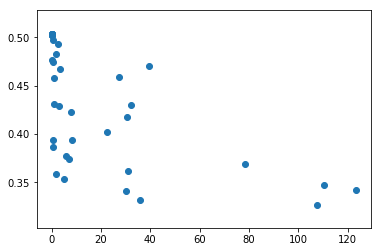

Best validation score:  0.5039277652370203
Best C:  0.029725770708089135


In [9]:
from sklearn import svm
from random import random

best_val = 0
best_C = 0
all_C_val_score = []
all_C = []
for i in range(40):
    log_C = random() * 10 - 5
    C = np.exp(log_C)
    clf = svm.LinearSVC(C=C, multi_class="ovr")
    clf.fit(X_train,y_train)
    val_score = clf.score(X_val,y_val)
    print("C=%f, val_score=%f" % (C, val_score))
    if val_score > best_val:
        best_val = val_score
        best_C = C
    all_C.append(C)
    all_C_val_score.append(val_score)

plt.scatter(all_C, all_C_val_score)
plt.show()
print("Best validation score: ", best_val)
print("Best C: ", best_C)

## Run Result

In [56]:
from sklearn import svm

best_C = 0.029725770708089135
clf = svm.LinearSVC(C=best_C, multi_class="ovr")
clf.fit(X_all_train, y_all_train)
print("Train score: ", clf.score(X_train, y_train))
print("Test score: ", clf.score(X_test, y_test))

Train score:  0.5039618935819582
Test score:  0.4984830973707021


# kNN

## Hyperparameter Tuning using CV

## Try it

In [57]:
X = dataset.drop(["Casualty_Severity", "Age_of_Casualty"], axis=1)
y = dataset["Casualty_Severity"]
from sklearn.model_selection import train_test_split
X_all_train, X_test, y_all_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6357)
X_train, X_val, y_train, y_val = train_test_split(X_all_train, y_all_train, test_size=0.2, random_state=6357)
del X, y
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(44297, 70)
(11075, 70)
(13844, 70)


In [60]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
knn.fit(X_all_train, y_all_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
           weights='uniform')

In [62]:
knn.score(X_test, y_test)

0.46330540306269863

In [ ]:
best_val = 0
best_n = 0
best_weights = ""
best_metric = ""
for n in range(1,20):
    for weights in ["uniform", "distance"]:
        for metric in ["euclidean", "manhattan", "chebyshev", "minkowski"]:
            knn = KNeighborsClassifier(n_neighbors=n, weights=weights, metric=metric, n_jobs=-1)
            knn.fit(X_train,y_train)
            val_score = knn.score(X_val, y_val)
            print("n=%d, weights=%s, metric=%s, val_score=%f" % (n, weights, metric, val_score))
            if val_score > best_val:
                best_val = val_score
                best_n = n
                best_weights = weights
                best_metric = metric
print("Best validation score: ", best_val)
print("Best n: ", best_n)
print("Best weights method: ", best_weights)
print("Best distance metric: ", best_metric)

n=1, weights=uniform, metric=euclidean, val_score=0.411196
n=1, weights=uniform, metric=manhattan, val_score=0.411196
n=1, weights=uniform, metric=chebyshev, val_score=0.399549
n=1, weights=uniform, metric=minkowski, val_score=0.411196
n=1, weights=distance, metric=euclidean, val_score=0.411196
n=1, weights=distance, metric=manhattan, val_score=0.411196
n=1, weights=distance, metric=chebyshev, val_score=0.399549
n=1, weights=distance, metric=minkowski, val_score=0.411196
n=2, weights=uniform, metric=euclidean, val_score=0.407404
n=2, weights=uniform, metric=manhattan, val_score=0.407585
n=2, weights=uniform, metric=chebyshev, val_score=0.400000
n=2, weights=uniform, metric=minkowski, val_score=0.407404
n=2, weights=distance, metric=euclidean, val_score=0.405779
n=2, weights=distance, metric=manhattan, val_score=0.406321
n=2, weights=distance, metric=chebyshev, val_score=0.401535
n=2, weights=distance, metric=minkowski, val_score=0.405779
n=3, weights=uniform, metric=euclidean, val_scor

In [12]:
knn = KNeighborsClassifier(n_neighbors=best_n, weights=best_weights, metric=best_metric, n_jobs=-1)
knn.fit(X_train,y_train)
print("Test score: ", knn.score(X_test, y_test))

Test score:  0.46850621207743426


In [14]:
from sklearn.neighbors import KNeighborsClassifier
error_rate = []
for n in range(1,80):
    knn = KNeighborsClassifier(n_neighbors=n, weights="uniform", metric="manhattan", n_jobs=-1)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_val)
    error_rate.append(np.mean(pred_i != y_val))

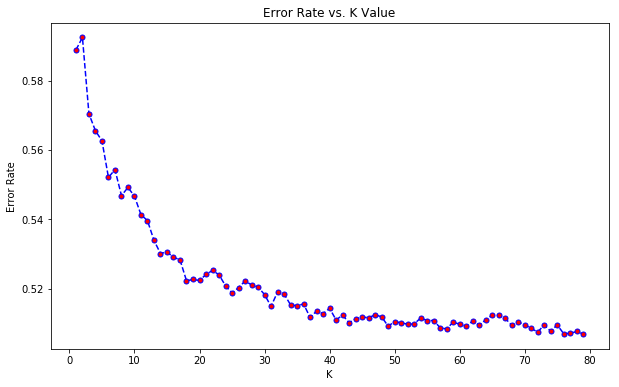

In [15]:
plt.figure(figsize=(10,6))
plt.plot(range(1,len(error_rate)+1),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=5)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()